## 1.2 Early Stop

우리는 이번 실습에서 Early Stopping을 하는 방법에 대해서 배워보고자 합니다. Early Stop은 학습을 너무 많이 시키면 모델이 과적합(overfitting)될 수 있기 때문에 overfitting이 되지 않도록 적당한 Epoch에서 학습을 멈춰주는 정규화 방법을 말합니다. 
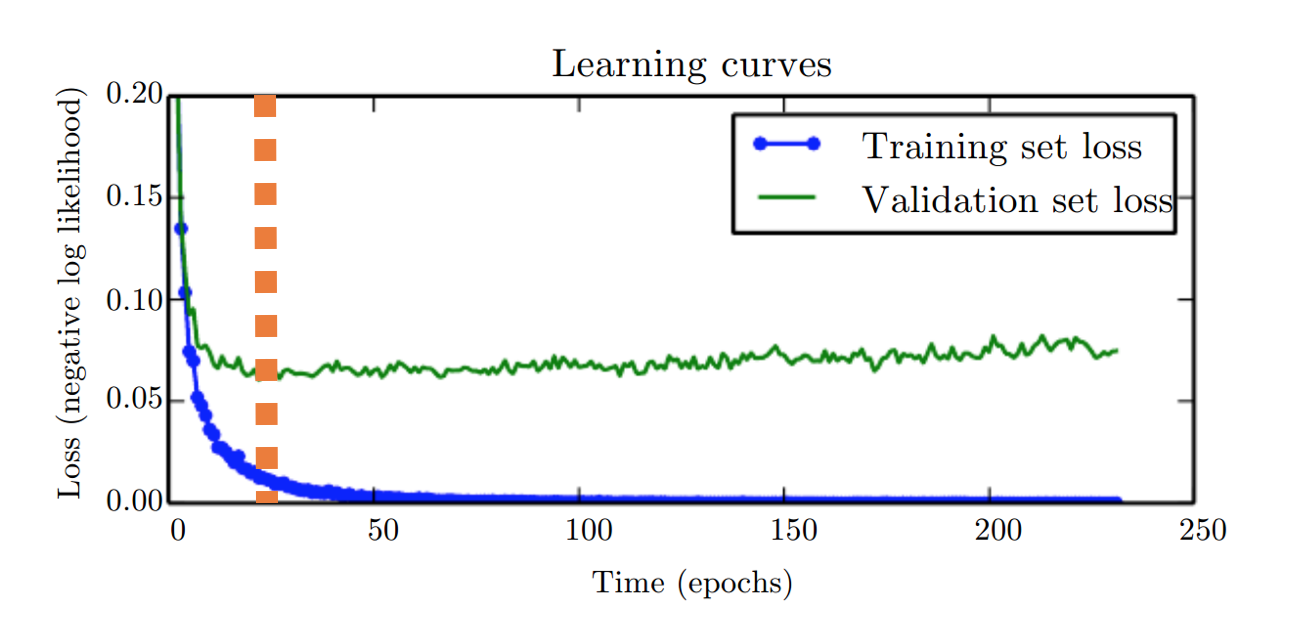
이전 실습과 대부분의 코드는 동일합니다. 

In [ ]:
import math
import random 

import tensorflow as tf
import numpy as np 

seed = 1
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1, 28 * 28])
x_test = x_test.reshape([-1, 28 * 28])

m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]

Early Stopping을 하기 위해 필요한 작업은 전체 1100개의 트레이닝 데이터에서 Validation 데이터를 떼는 것입니다. Training 데이터 셋 내에서 Validation set을 떼어낸 후에 Validation set 없이 학습을 진행하다가 Validation Error가 가장 최적인 때의 모델 파라미터를 최종 모델로 사용합니다. 아래 코드로 1100개의 트레이닝 데이터에서 100개를 Validation set으로 떼어냅니다. 통상적으로 10%~20%를 validation으로 떼어내는데, validation set이 너무 작으면 test set을 대변하지 못할 수도 있고 또 validation set이 너무 크면 모델 성능이 저하될 수 있으므로 적당한 수준으로 validation set을 떼어내는 작업이 중요합니다. 

In [ ]:
i = np.arange(1100)
np.random.shuffle(i)
x_train = x_train[i]
y_train = y_train[i]

x_valid = x_train[:100]
y_valid = y_train[:100]

x_train = x_train[100:]
y_train = y_train[100:]

이제 나머지 부분들은 이전 실습과 동일하게 진행합니다. 

In [ ]:
x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])

n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)
    
layer = x 
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.nn.tanh(layer)        
y_hat = layer

y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
loss = cross_entropy_loss 

accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)
    
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

각 Epoch별 train/valid/test accuracy, loss를 측정하기 위한 리스트 변수들을 선언합니다.

In [ ]:
train_accuracy_values, valid_accuracy_values, test_accuracy_values = [], [], []
train_loss_values, valid_loss_values, test_loss_values = [], [], []

학습을 진행합니다. 총 1000번의 Epoch을 수행합니다. 총 100 Epoch 동안 성능 개선이 이뤄지지 않으면 Early Stop 합니다. Early stop은 accuracy 기준으로 진행합니다. (Quiz: 왜 Loss 기준으로 진행하지는 않을까요?)

In [ ]:
max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0
for epoch_idx in range(1, 1000 + 1):
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train
            })
        
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test
            })

        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value, '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        train_accuracy_values.append(train_accuracy_value)
        valid_accuracy_values.append(valid_accuracy_value)
        test_accuracy_values.append(test_accuracy_value)

        train_loss_values.append(train_loss_value)
        valid_loss_values.append(valid_loss_value)
        test_loss_values.append(test_loss_value)
        
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value 
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value
            
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print(max(test_accuracy_values))
print(final_test_accuracy)

우리는 이 네트워크가 최고 88.34%의 Test Accuracy를 나타내고, Early Stop을 수행한 시점의 모델 성능은 88.05% 임을 확인할 수 있었습니다. 물론 최고 Test Accuracy와는 다소 차이가 있지만 Early Stopping을 통해 적당한 epoch 수를 자동으로 찾아낼 수 있었습니다. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(train_accuracy_values, label="train")
plt.plot(valid_accuracy_values, label="valid")
plt.plot(test_accuracy_values, label="test")
plt.ylabel('Accuracy')
plt.xlabel('Epoch x10')
plt.ylim([0.8, 1.0])
plt.axhline(y=max(test_accuracy_values), color='r', linestyle='-')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_values, label="train")
plt.plot(valid_loss_values, label="valid")
plt.plot(test_loss_values, label="test")
plt.ylabel('Loss')
plt.xlabel('Epoch x10')
plt.axhline(y=min(test_loss_values), color='r', linestyle='-')
plt.ylim([0, 0.6])
plt.legend(loc='upper right')
plt.show()

Validation Set이 overfitting하기 시작하는 시점이 Test set이 overfitting하기 시작하는 시점과 상당히 유사한 것을 알 수 있습니다. 

다음 [실습](01_03_input_layer_stabilization.ipynb)에서는 Input Layer 안정화 방식에 대해서 배워보고자 합니다.